In [1]:
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import crystalball
from scipy.optimize import curve_fit,Bounds
from scipy.integrate import simps
import zfit_physics as zphysics
import zfit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import mplhep
import uncertainties 
from uncertainties import ufloat
import tensorflow as tf

plt.style.use('belle2')
#%jsroot on


%run /afs/desy.de/user/j/jipatel/MT/MC_fit/Files_After_Acceptance/Signal_Background_thesis_final/Function.ipynb

2024-09-03 11:12:14.234938: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 11:12:14.305095: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-03 11:12:14.306067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 11:12:16.628055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warnin

In [2]:
file_bkg_mu="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/background/B0mumupip4Streams.root"
file_signal_mu="/pnfs/desy.de/belle/local/user/msobotzi/p5prime/FilesAfterAcceptance/MC15/signal/B0mumupip4Streams.root"


In [3]:
mc_mu_signal,mc_mu_only_signal,mc_mu_scf,mc_mu_bkg, mc_mu_signal_weight,mc_mu_only_signal_weight,mc_mu_scf_weight,mc_mu_bkg_weight = process_MC_data_combined(file_signal_mu, file_bkg_mu, 'mu', '511', 'pip', 'mumu', 1, 'rec511','PIDCorrectionAndAcceptanceWeight')


In [4]:
#fit_and_integrate(mc_mu_signal, param_fl_start=0.5, param_s3_start=0.01, param_p5_start=0.02, floating=True)


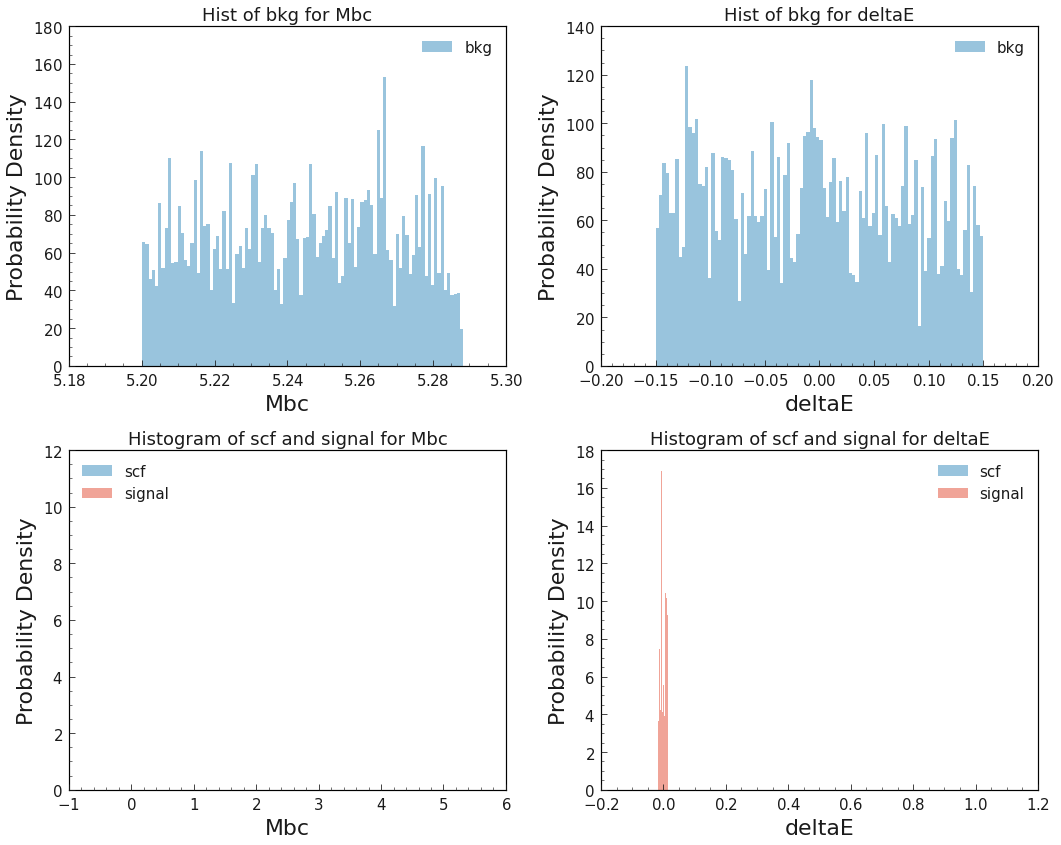

In [5]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Mbc_bkg
plot_histogram(axs[0, 0], {"bkg":  mc_mu_bkg["Mbc"]},
               ["bkg"],
               {"bkg": mc_mu_bkg_weight},
               'Mbc', 'Probability Density', 'Hist of bkg for Mbc')

# deltaE_bkg
plot_histogram(axs[0, 1], {"bkg": mc_mu_bkg["deltaE"]},
               ["bkg"],
               {"bkg": mc_mu_bkg_weight},
               'deltaE', 'Probability Density', 'Hist of bkg for deltaE')

# Mbc_signal 
plot_histogram(axs[1, 0], {"scf": mc_mu_scf["Mbc"], 
                           "signal": mc_mu_only_signal["Mbc"]}, 
               ["scf", "signal"],
               {"scf": mc_mu_scf_weight, "signal": mc_mu_only_signal_weight}, 
               'Mbc', 'Probability Density', 'Histogram of scf and signal for Mbc')


# deltaE_signal
plot_histogram(axs[1, 1], {"scf": mc_mu_scf["deltaE"], 
                           "signal": mc_mu_only_signal["deltaE"]}, 
               ["scf", "signal"],
               {"scf": mc_mu_scf_weight, "signal": mc_mu_only_signal_weight},
               'deltaE', 'Probability Density', 'Histogram of scf and signal for deltaE')


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Yield

In [6]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed('deltaE','mu', 'signal',mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight,'cb_gauss',0)


#scf
Mbc_scf_argus_gauss_fixed= fit_fixed('Mbc','mu', 'scf', mc_mu_scf["Mbc"], mc_mu_scf_weight,'argus_gauss',0)
deltaE_scf_poly_gauss_fixed= fit_fixed('deltaE','mu', 'scf', mc_mu_scf["deltaE"], mc_mu_scf_weight,'poly_gauss',0)


#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed('Mbc','mu', 'bkg',  mc_mu_bkg["Mbc"], mc_mu_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed('deltaE','mu', 'bkg',  mc_mu_bkg["deltaE"], mc_mu_bkg_weight,'poly',0)



In [7]:
Signal_Mbc = mc_mu_only_signal["Mbc"]
Signal_deltaE = mc_mu_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_mu_scf["Mbc"],mc_mu_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_mu_scf["deltaE"],mc_mu_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_mu_only_signal_weight
Background_weight = pd.concat([mc_mu_scf_weight,mc_mu_bkg_weight])


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model_scf(
    Mbc_only_signal_cb_fixed,Mbc_scf_argus_gauss_fixed,deltaE_only_signal_cb_gauss_fixed,deltaE_scf_poly_gauss_fixed,
    Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),0.1,0.1,100,1000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.3461                 220.328  -     19   +     20       False
background_yield_0.3461             6826.63  -     85   +     83       False
frac_Mbc_bkg1_0.3461              -0.135574  -   0.02   +  0.019       False
frac_deltaE_bkg1_0.3461          0.00968705  -   0.06   +  0.058       False
True


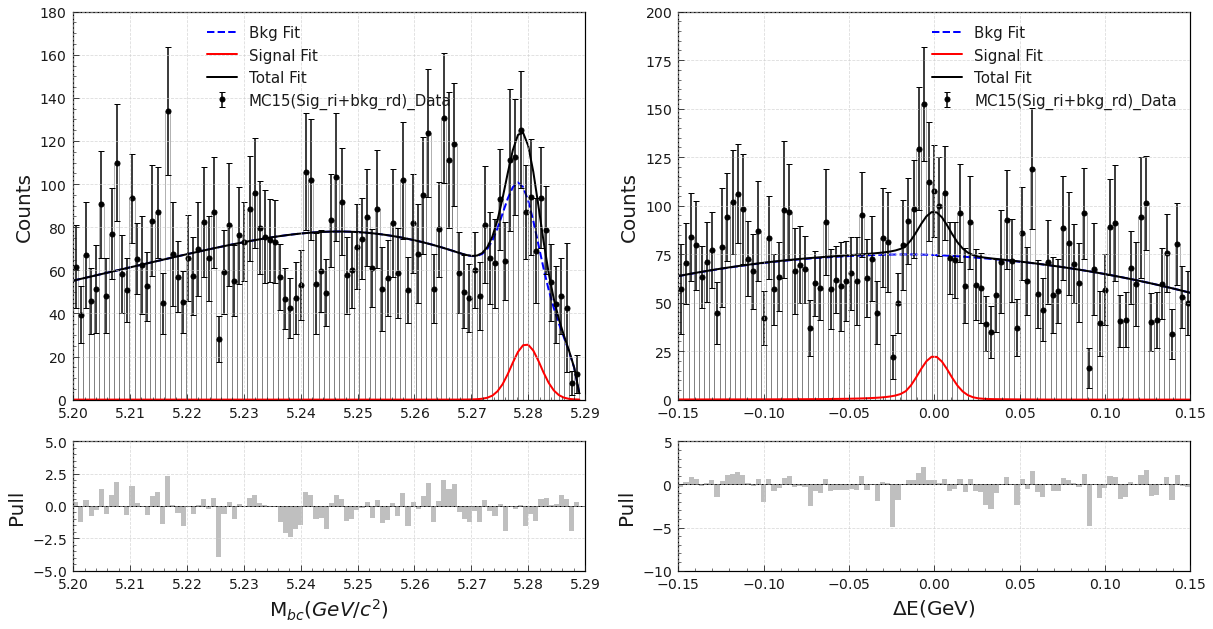

In [8]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15(Sig_ri+bkg_rd)_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
#plt.savefig('B0pip_q2reg1_decay_mumu.pdf')
plt.show()
   


In [9]:
# signal
Mbc_only_signal_cb_fixed = fit_fixed('Mbc','mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight,'cb',0)
deltaE_only_signal_cb_gauss_fixed= fit_fixed('deltaE','mu', 'signal',mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight,'cb_gauss',0)

#bkg
Mbc_bkg_argus_gauss_fixed= fit_fixed('Mbc','mu', 'bkg',  mc_mu_bkg["Mbc"], mc_mu_bkg_weight,'argus_gauss',0)
deltaE_bkg_poly_gauss_fixed= fit_fixed('deltaE','mu', 'bkg',  mc_mu_bkg["deltaE"], mc_mu_bkg_weight,'poly',0)



In [10]:
Signal_Mbc = mc_mu_only_signal["Mbc"]
Signal_deltaE = mc_mu_only_signal["deltaE"]

Background_Mbc = pd.concat([mc_mu_scf["Mbc"],mc_mu_bkg["Mbc"]])
Background_deltaE = pd.concat([mc_mu_scf["deltaE"],mc_mu_bkg["deltaE"]])

Signal_total = pd.concat([Signal_Mbc, Signal_deltaE], axis=1)
Background_total = pd.concat([Background_Mbc, Background_deltaE], axis=1)


Signal_weight = mc_mu_only_signal_weight
Background_weight = pd.concat([mc_mu_scf_weight,mc_mu_bkg_weight])

print(sum(Signal_weight))
print(sum(Background_weight))


Mbc_signal_pdf,deltaE_signal_pdf,Mbc_background_pdf,deltaE_background_pdf,signal_extended, background_extended, total_model, result = fit_extended_model(
    Mbc_only_signal_cb_fixed,deltaE_only_signal_cb_gauss_fixed,Mbc_bkg_argus_gauss_fixed,deltaE_bkg_poly_gauss_fixed,
    pd.concat([Signal_total, Background_total]),
    pd.concat([Signal_weight, Background_weight]),100,1000
)

#result.hesse(name='hesse')
result.errors(name='errors')
print(result.params)
print(result.valid)


185.2784390027047
6860.300116100237


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.2015                 209.489  -     19   +     20       False
background_yield_0.2015             6836.09  -     83   +     84       False
True


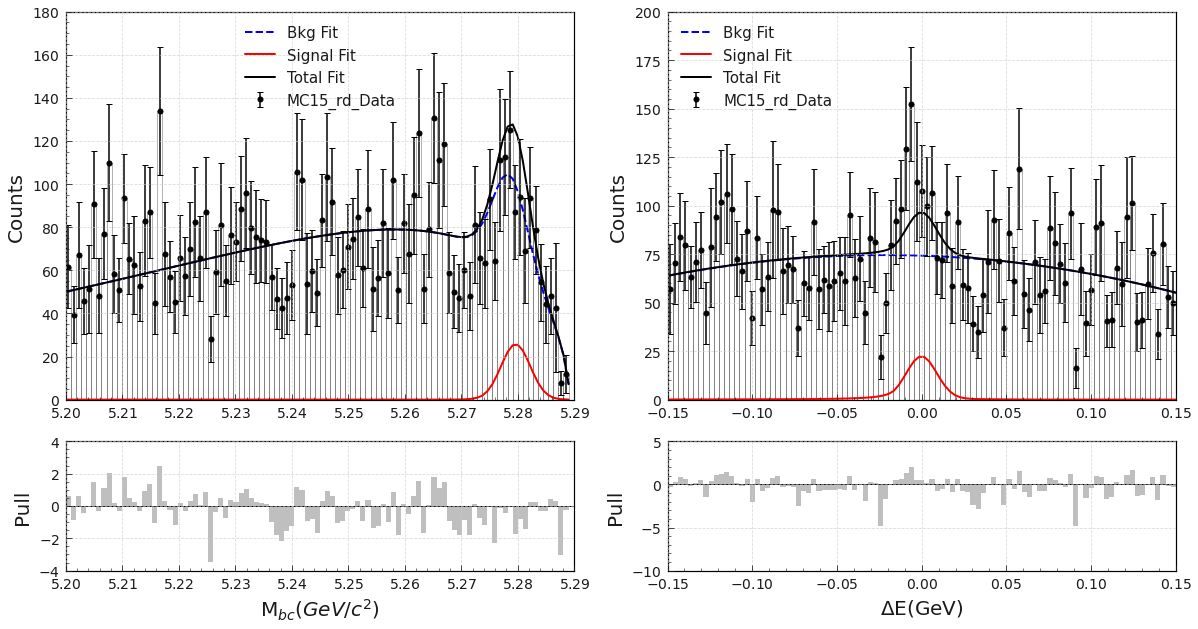

In [11]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'height_ratios': [3, 1]})

# Plot Mbc
plot_variable(axs[0, 0], axs[1, 0], "Mbc", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,Mbc_signal_pdf, Mbc_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data", "M$_{bc}(GeV/c^2)$")

# Plot deltaE
plot_variable(axs[0, 1], axs[1, 1], "deltaE", mc_mu_signal,mc_mu_scf, mc_mu_bkg,mc_mu_signal_weight,mc_mu_scf_weight,
              mc_mu_bkg_weight,deltaE_signal_pdf, deltaE_background_pdf, "Signal Fit", "Bkg Fit","MC15_rd_Data","$\\Delta$E(GeV)")


# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('B0pip_q2reg1_decay_mumu_rd.pdf')
plt.show()
   


/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/core/basepdf.py:585: UserWarning: As `copy` is not yet properly implemented, this may fails (for ProductPDF for example?). Thiswill be fixed in the future.
  warnings.warn(
/afs/desy.de/user/j/jipatel/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.1293                 7966.08  -     93   +     94       False
background_yield_0.1293             8272.75  -     95   +     95       False
True
name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.8267                 51287.3  -2.3e+02   +2.4e+02       False
background_yield_0.8267             50361.3  -2.3e+02   +2.4e+02       False
True
name                       value  (rounded)               errors    at limit
-----------------------  ------------------  -------------------  ----------
signal_yield_0.3752                  205962  -4.7e+02   +4.7e+02       False
background_yield_0.3752              200797  -4.7e+02   +4.7e+02       False
True
name                       value  (rounded)               err

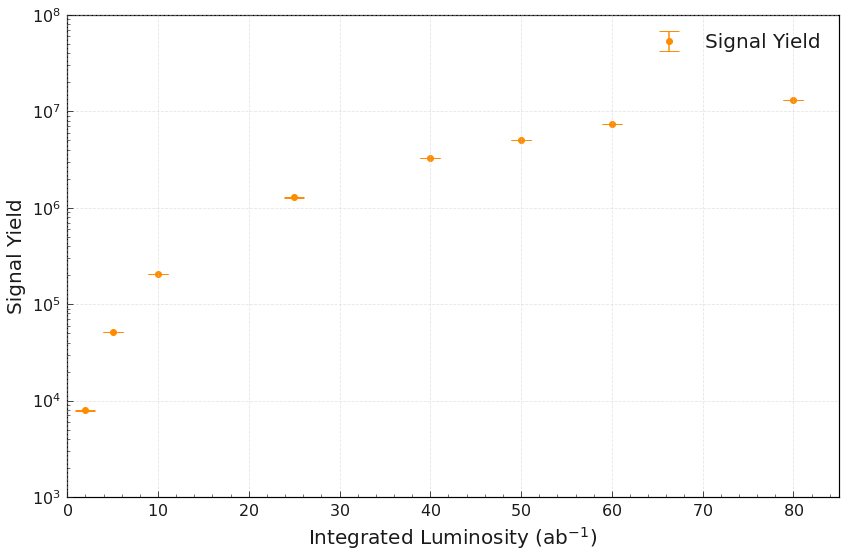

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uncertainties import ufloat  # Ensure you import this for uncertainty handling

# Assuming result is some fitting result object with parameters
signal_yield_value = result.params[signal_extended.get_yield()]['value']
signal_yield_errors = result.params[signal_extended.get_yield()]['errors']

# Calculate the symmetric uncertainty assuming you have upper and lower errors
signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2
signal_yield_with_uncertainty = ufloat(signal_yield_value, signal_yield_error)

normalization_factor = 0.368 * 4  # Fixed normalization factor

# Define your PDFs using whatever function you have for fitting
Mbc_only_signal_cb_fixed = fit_fixed('Mbc', 'mu', 'signal', mc_mu_only_signal["Mbc"], mc_mu_only_signal_weight, 'cb', 0)
deltaE_only_signal_cb_gauss_fixed = fit_fixed('deltaE', 'mu', 'signal', mc_mu_only_signal["deltaE"], mc_mu_only_signal_weight, 'cb_gauss', 0)
Mbc_bkg_argus_gauss_fixed = fit_fixed('Mbc', 'mu', 'bkg', mc_mu_bkg["Mbc"], mc_mu_bkg_weight, 'argus_gauss', 0)
deltaE_bkg_poly_fixed = fit_fixed('deltaE', 'mu', 'bkg', mc_mu_bkg["deltaE"], mc_mu_bkg_weight, 'poly', 0)

# Define luminosities to loop over
luminosities = [2, 5, 10, 25,40, 50,60, 80]

# Calculate the number of events per ab^-1
n_events_per_ab1 = signal_yield_value / normalization_factor

# Arrays to store results
signal_yields = []

for lumi in luminosities:
    # Calculate the number of events for this luminosity
    n_events = int(lumi * n_events_per_ab1)  # Convert directly to an integer
    
    # Sample signal events
    Mbc_samples_signal = Mbc_only_signal_cb_fixed.sample(n=n_events).numpy()
    deltaE_samples_signal = deltaE_only_signal_cb_gauss_fixed.sample(n=n_events).numpy()

    # Combine Mbc and deltaE into a single DataFrame for signal
    samples_signal_df = pd.DataFrame({'Mbc': Mbc_samples_signal.flatten(), 'deltaE': deltaE_samples_signal.flatten()})
    
    # Calculate scaled weights for signal
    scaled_signal_weights = pd.Series((Mbc_samples_signal.flatten() + deltaE_samples_signal.flatten()) * (lumi / 0.368))
    
    # Sample background events
    Mbc_samples_bkg = Mbc_bkg_argus_gauss_fixed.sample(n=n_events).numpy()  # Use n_events directly
    deltaE_samples_bkg = deltaE_bkg_poly_fixed.sample(n=n_events).numpy()
    
    # Combine Mbc and deltaE into a single DataFrame for background
    samples_bkg_df = pd.DataFrame({'Mbc': Mbc_samples_bkg.flatten(), 'deltaE': deltaE_samples_bkg.flatten()})
    
    # Calculate scaled weights for background
    scaled_bkg_weights = pd.Series((Mbc_samples_bkg.flatten() + deltaE_samples_bkg.flatten()) * (lumi / 0.368))
    
    # Concatenate signal and background dataframes
    combined_df = pd.concat([samples_signal_df, samples_bkg_df], axis=0)
    
    # Concatenate weights for signal and background
    combined_weights = pd.concat([scaled_signal_weights, scaled_bkg_weights], axis=0)
    
    # Perform the fit with the combined data and weights
    Mbc_signal_pdf, deltaE_signal_pdf, Mbc_background_pdf, deltaE_background_pdf, signal_extended, background_extended, total_model, result = fit_extended_model(
        Mbc_only_signal_cb_fixed, deltaE_only_signal_cb_gauss_fixed, Mbc_bkg_argus_gauss_fixed, deltaE_bkg_poly_fixed,
        combined_df, combined_weights, 100, 100
    )

    # Optionally calculate errors or perform other fitting operations
    result.errors(name='errors')
    print(result.params)
    print(result.valid)

    # Retrieve and store the signal yield and its error
    signal_yield = result.params[signal_extended.get_yield()]['value']
    signal_yield_errors = result.params[signal_extended.get_yield()]['errors']
    signal_yield_error = (signal_yield_errors['upper'] - signal_yield_errors['lower']) / 2

    # Store the signal yield and error as a tuple in the list
    signal_yields.append((lumi, signal_yield, signal_yield_error))

# Convert the list to a DataFrame with columns for luminosity, signal yield, and its error
events_per_luminosity = pd.DataFrame(signal_yields, columns=['luminosity', 'signal_yield', 'signal_yield_error'])

# Extract data for plotting
luminosities = events_per_luminosity['luminosity']
signal_yields = events_per_luminosity['signal_yield']
signal_yield_errors = events_per_luminosity['signal_yield_error']

print(luminosities)
print(signal_yields)
print(signal_yield_errors)

# Plot the Signal Yield vs. Luminosity
plt.figure(figsize=(12, 8))
plt.errorbar(luminosities, signal_yields, yerr=signal_yield_errors, fmt='o', capsize=10, label='Signal Yield', color='darkorange')

#plt.title('Signal Yield vs. Integrated Luminosity', fontsize=20, fontweight='bold')
plt.xlabel('Integrated Luminosity (ab$^{-1}$)', fontsize=20)
plt.yscale("log")
plt.ylabel('Signal Yield', fontsize=20)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=20)

plt.xlim(0, 85)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig("B0pip_q2reg1_decay_mumu_Signal_Yield_Integrated_Luminosity.pdf", format='pdf')  # Corrected this line
plt.show()

